In [1]:
import numpy as np
import pylab as plt
plt.ion()

In [2]:
!nrnivmodl > null.out

# Model setting

In [3]:
from neuron import h
soma = h.Section(name='soma')

soma.L = 10
soma.diam = 10
soma.insert('sodium')
soma.insert('potassium')
soma.insert('leak')

soma

## Set active channels off

In [4]:
soma.gnabar_sodium = 0
soma.gkbar_potassium = 0
soma.gl_leak = 0.0003

In [5]:
tstop = 100
onset = 20
dur = tstop - 2 * onset

## Define inputs

In [6]:
# step current
iclamp = h.IClamp(soma(0.5))
iclamp.delay = onset
iclamp.dur = dur
iclamp.amp = 0.008 # (nA)

# record voltage and time
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

# Run simulation

In [7]:
h.load_file('stdrun.hoc')
h.finitialize(-65)
h.tstop = tstop
h.run()

0.0

(-54.51373316164802, -45.561736508171336)

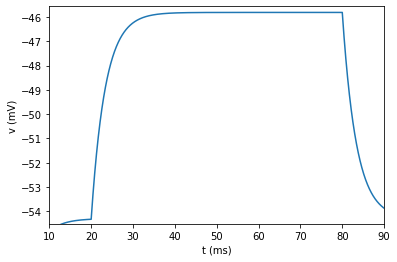

In [8]:
v_arr = np.array(v)
t_arr = np.array(t)

plt.figure()
plt.plot(t_arr, v_arr)
plt.xlim(onset-10, (onset+dur)+10)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')

# set ylim
idx_t = np.where((t_arr>onset)&(t_arr<(onset+dur)))[0]
plt.ylim(v_arr[idx_t].min()-0.25,v_arr[idx_t].max()+0.25)

# Passive properties

In [9]:
from scipy.optimize import curve_fit
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

def func_exp_grow(x, v0, delta_v, x0, tau):
    """Decaying exponential function."""
    return v0 + delta_v * (1-np.exp(-(x-x0)/tau))

x = t_arr[idx_t]
y_sim = v_arr[idx_t]

popt, _ = curve_fit(func_exp_grow, x, y_sim, p0=[-54, 5, 20, 10], bounds=([-100, 0, 19.99, 0.001], [100, 100, 20.01, 100]))

In [10]:
popt

array([-54.32506872,   8.51333235,  20.00080731,   3.34581777])

In [11]:
y_fit = func_exp_grow(x,*popt)

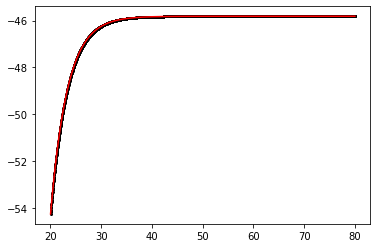

In [12]:
plt.plot(x, y_sim, 'ko', markersize=2)
plt.plot(x, y_fit, 'r-')

In [13]:
tau_cut_off = soma.cm * (1/soma.gl_leak) * 1e-6 * 1e3  # ms
print(tau_cut_off)

3.3333333333333335


In [14]:
def func_lin(x, q, m):
    """Decaying exponential function."""
    return q + m * x

input resistance from fit = 1.05931e+09 (Ohm)


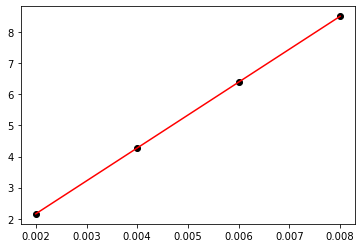

In [15]:
# experiment with soma.gl_leak = 0.0003

dv=np.array([2.15445477, 4.28288189, 6.39247078, 8.51333235])
icc=np.array([0.002, 0.004, 0.006, 0.008])

popt_lin, _ = curve_fit(func_lin, icc, dv)

Rin = popt_lin[1] * 1e6
print('input resistance from fit = %g (Ohm)' % Rin)

plt.plot(icc,dv,'ko')
plt.plot(icc,func_lin(icc,*popt_lin),'r-');

In [17]:
surface = soma.L * soma.diam * np.pi # um2 #  = soma(0.5).area() 
gleakage = surface * soma.gl_leak * 1e-8 # um^2*S/cm^2 = 10^-12/10^-4 = 10^-8
Rleak = 1/gleakage
print('input resistance of the model = %g (Ohm)' % Rleak)

input resistance of the model = 1.06103e+09 (Ohm)
